# Calculate uncertainties in geodetic mass balance

## A brief introduction

The method is based on Hugonnet et al. (2022) and assess the uncertainty at 1-sigma level from the spatial correlation and the heteroscedacity of elevation change.

Hereafter, we follow three tutorials:
- assessing the spatial correlation: https://xdem.readthedocs.io/en/latest/basic_examples/plot_infer_spatial_correlation.html
- assessing the heteroscedasticity of the data: https://xdem.readthedocs.io/en/latest/advanced_examples/plot_heterosc_estimation_modelling.html
- propagating the uncertainty: https://xdem.readthedocs.io/en/latest/basic_examples/plot_spatial_error_propagation.html

## Load the relevant packages

In [1]:
import geoutils as gu
import xdem
import numpy as np
import matplotlib.pyplot as plt

## Load the relevant data

In [2]:
path = "/Users/adehecq/work/south_col_glacier/data/"

dh_map = path + "1984_2017_dh_WesternCwm_2m.tif"
shp_gla = path + "GAMDAM_Everest_sub.shp"
ref_DEM_file = path + "Khumbu_2017-03-23_DEM_4m.tif"

dh = xdem.DEM(dh_map)
ref_dem = xdem.DEM(ref_DEM_file)
glacier_outlines = gu.Vector(shp_gla)

## Make sure all datasets are in the same proj and grid

In [3]:
dh = dh.reproject(ref_dem, silent=True)

In [4]:
glacier_outlines = gu.Vector(glacier_outlines.ds.to_crs(dh.crs))

## Optional: plot the dh map and DEM

(3083354.0, 3101266.0)

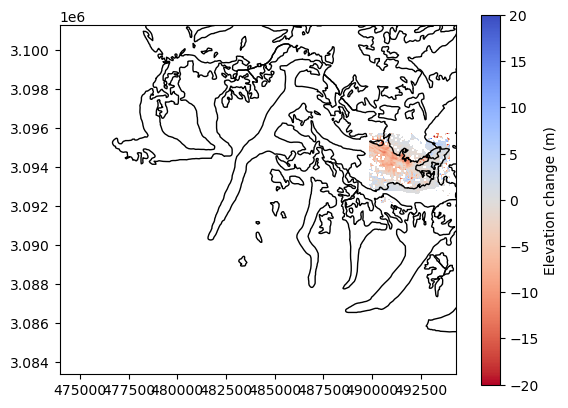

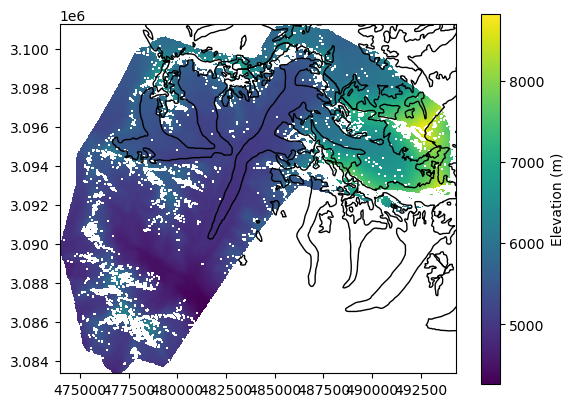

In [5]:
plt.figure()
ax = plt.subplot(111)
dh.show(ax=ax, cmap="coolwarm_r", vmin=-20, vmax=20, cb_title="Elevation change (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

plt.figure()
ax = plt.subplot(111)
ref_dem.show(ax=ax, cmap="viridis", cb_title="Elevation (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

## Empirical variogram and plot
Increase the default subsample size (default 1000) and draw 5 variograms, to make results more reliable

In [6]:
(
    df_empirical_variogram,
    df_model_params,
    spatial_corr_function,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=dh,
    list_models=["Spherical", "Spherical"],
    unstable_mask=glacier_outlines,
    subsample=4000,
    n_variograms=5,
    n_jobs=4,
)

print("Model parameters:")
print(f"Model 1: range = { df_model_params.iloc[0].range:.2f} m, sill = {df_model_params.iloc[0].psill:.2f} m^2")
print(f"Model 2: range = { df_model_params.iloc[1].range:.2f} m, sill = {df_model_params.iloc[1].psill:.2f} m^2")

/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model parameters:
Model 1: range = 77.92 m, sill = 7.47 m^2
Model 2: range = 6160.73 m, sill = 0.99 m^2


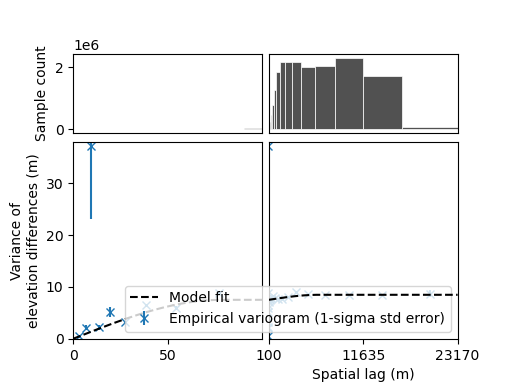

In [7]:
xdem.spatialstats.plot_variogram(
    df=df_empirical_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(df_model_params)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m)",
    xscale_range_split=[
        100,
    ],
)

## Estimate heteroscedasticity

In [8]:
slope, max_curv = xdem.terrain.get_terrain_attribute(ref_dem, attribute=["slope", "maximum_curvature"])

slope_bins = np.arange(0, 90, 5)
max_curv_bins = np.nanquantile(max_curv.data.compressed(), np.linspace(0.02, 0.98, 100))

errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=dh,
    list_var=[slope, max_curv],
    list_var_names=["slope", "maxc"],
    unstable_mask=glacier_outlines,
    list_var_bins=[slope_bins, max_curv_bins],
)

zscores = dh / errors

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/adehecq/development/GlacioHack/xdem/xdem/terrain.py:996: RuntimeWarning: invalid value encountered in true_divide
  -2
/Users/adehecq/development/GlacioHack/xdem/xdem/terrain.py:1026: RuntimeWarning: invalid value encountered in true_divide
  2


## Show dependency of error with slope and curvature

### Plot error as a function of slope

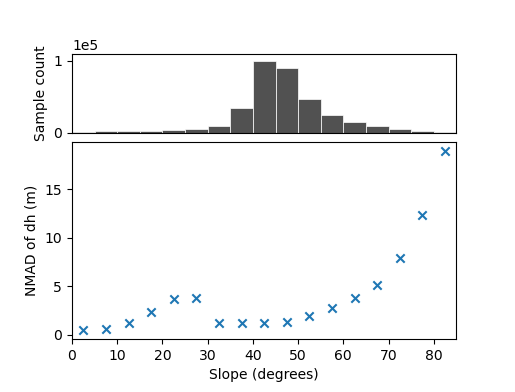

In [9]:
xdem.spatialstats.plot_1d_binning(
    df_binning, var_name="slope", statistic_name="nmad", label_var="Slope (degrees)", label_statistic="NMAD of dh (m)"
)

DEM errors are higher in areas of steep slope.

### Plot error as a function of maximum curvature

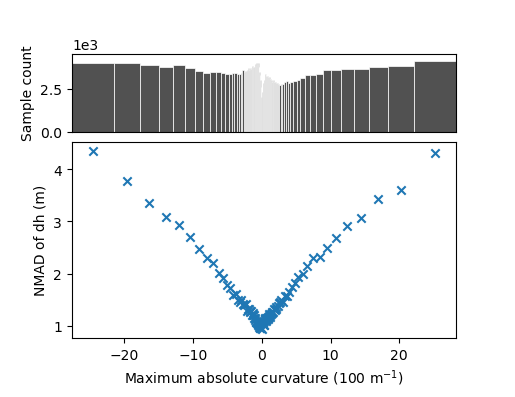

In [10]:
xdem.spatialstats.plot_1d_binning(
    df_binning,
    var_name="maxc",
    statistic_name="nmad",
    label_var="Maximum absolute curvature (100 m$^{-1}$)",
    label_statistic="NMAD of dh (m)",
)

DEM errors increase with terrain maximum curvature

### Plot error as a function of both

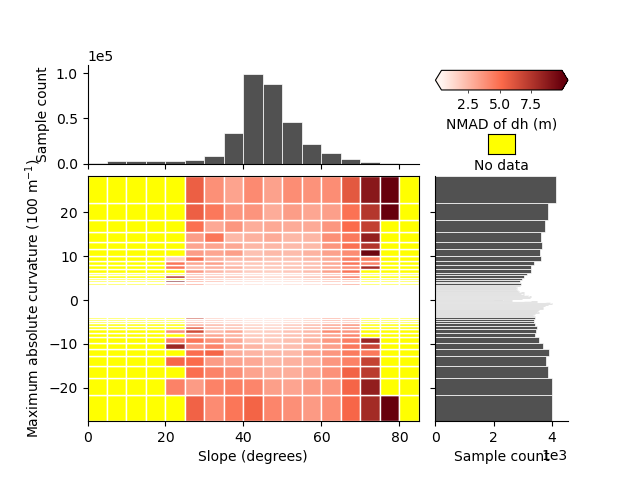

In [11]:
xdem.spatialstats.plot_2d_binning(
    df_binning,
    var_name_1="slope",
    var_name_2="maxc",
    statistic_name="nmad",
    label_var_name_1="Slope (degrees)",
    label_var_name_2="Maximum absolute curvature (100 m$^{-1}$)",
    label_statistic="NMAD of dh (m)",
)

In general, errors are higher for areas of steep slope and higher curvature.

### Plot explained error map

This modelled or explained error is estimated at any pixel from the terrain slope and curvature. 

(3083354.0, 3101266.0)

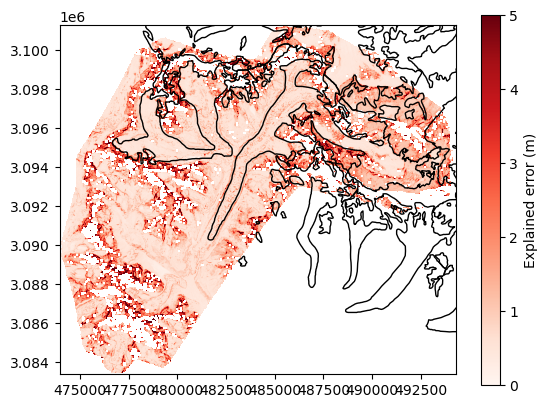

In [12]:
plt.figure()
ax = plt.subplot(111)
errors.show(ax=ax, cmap="Reds", vmin=0, vmax=5, cb_title="Explained error (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

### Calculate mean explained error on stable terrain and on South Col glacier

In [13]:
glacier_mask = glacier_outlines.create_mask(dh).squeeze()
scg_outlines = gu.Vector(glacier_outlines.ds[glacier_outlines.ds["FID_1"] == 3643])
scg_mask = scg_outlines.create_mask(dh)

print(f"Mean explained error on stable terrain: {np.mean(errors.data[0][~glacier_mask]):.2f} m")
print(f"Mean explained error on SCG: {np.mean(errors.data[scg_mask]):.2f} m")

Mean explained error on stable terrain: 1.77 m
Mean explained error on SCG: 0.79 m


Because SCG is less steep and has lower curvature compared to the average stable terrain over the DEM area, the explained error is smaller on SCG. This explains why the final estimated uncertainty (below) can be smaller than the NMAD over stable terrain. 

## Spatial integration of variance on the target area

In [14]:
# areas = [glacier_outlines.ds[glacier_outlines.ds["NAME"] == "SCG"]]
areas = [glacier_outlines.ds[glacier_outlines.ds["FID_1"] == 3643]]

stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=df_model_params
)

for glacier_name, stderr_gla in [("SCG", stderr_glaciers[0])]:
    print(f"The error (1-sigma) in mean elevation change for {glacier_name} is {stderr_gla:.2f} meters.")

The error (1-sigma) in mean elevation change for SCG is 0.28 meters.
